# Photon Counting
1) Grab Data

2) Threshold Frames by 5*Read Noise

3) Sum frames along temporal dimension

4) Apply Nemati (2020) 3rd order photometric correction

5) Subtract background (avg of 6x6 pixels in the corner)

In [18]:
import numpy as np
import resample2D

def threshold(factor,readnoise,frame):
    """
    Binary Threshold
    factor = 5*readnoise
    readnoise = 100 e-
    frame = frame to threshold
    """
    
    thresh = factor*readnoise
    
    frame[frame<thresh] = 0
    frame[frame>thresh] = 1
    
    return frame

def photCorrPC(nobs,nfr,t,g):
    """
    Photon counting to 3rd order correction, typical parameters are
    nobs =  
    t = 5*100 e-/frame
    g = 6000 e-/photoelectron
    nbr = lam_br * Nfr * eth * ecl
    
    This should return the mean expected photon rate per-pixel
    
    
    """
    
    lam_est = -np.log(1-(nobs/nfr))*np.exp(t/g)
    lam_est -= deltaLam(lam_est,t,g,nfr,nobs)
    lam_est -= deltaLam(lam_est,t,g,nfr,nobs)
    
    return lam_est

def deltaLam(lam,t,g,nfr,nobs):
    """
    
    Parameters
    ----------
    lam : float
        mean expected rate per pixel per frame from photCorrPC
    t : float
        threshold chosen for photon counting
    g : float
        EM Gain
    nfr : float
        number of frames
    nobs : float
        sum of counts across all frames after thresholding
    
    From B. Nemati 7 Nov 2020
    
    Returns
    -------
    dlam
    
    """
    
    epsThr_a = np.exp(-t/g)*(t**2 * lam**2 + 2*g*t*lam*(3+lam) + 2*g**2 *(6+3*lam + lam**2))
    epsThr_b = (2*g**2 *(6+3*lam + lam**2))
    epsThr3  = epsThr_a/epsThr_b
    
    epsCL = (1-np.exp(lam))/lam
    func  = lam*nfr*epsThr3*epsCL - nobs
    
    dfdlam_a = (1/(2*g**2 *(6+3*lam+lam**2)))
    dfdlam_b = np.exp(-t/g - lam)*nfr
    dfdlam_c = 2*g**2 *(6+3*lam+lam**2)**2 + t**2 *lam*(-12 + 3*lam +3*lam**2 + lam**3 + 3*np.exp(lam)*(4+lam))
    dfdlam_d = 2*g*t*(-18 +6*lam +15*lam**2 + 6*lam**3 +lam**4 + 6*np.exp(lam)*(3+2*lam))
    
    dfdlam   = dfdlam_a*dfdlam_b*(dfdlam_c+dfdlam_d)
    
    dlam = func/dfdlam
    
    return dlam

from astropy.io import fits
import matplotlib.pyplot as plt
pth = '/home/uasal-optics/Desktop/os9_hlc_muf/muf_os9_ccd_images_no_planets.fits'

# Get target and reference data with MUFs
data = fits.getdata(pth).astype(float)


# Load data
def processcube(data,ID):
    
    # image indices for each Star ID
    if ID == 1:
        mind = 0
        mand = 59
        frames = 60
        
    elif ID == 2:   
        mind = 60
        mand = 1079
        frames = 1020
        
    elif ID == 3:
        mind = 1080
        mand = 2339
        frames = 1260
        
    elif ID == 4:
        mind = 2340
        mand = 3601
        frames = 1260
        
    elif ID == 5:
        mind = 3602
        mand = 4860
        frames = 1260
        
    elif ID == 6:
        mind = 4861
        mand = 4925
        frames = 60
        
    elif ID == 7:
        mind = 4926
        mand = 4985
        frames = 60
        
    elif ID == 8:
        mind = 4986
        mand = 6005
        frames = 1020
        
    elif ID == 9:
        mind = 6006
        mand = 7265
        frames = 1260
        
    elif ID == 10:
        mind = 7626
        mand = 8525
        
    elif ID == 11:
        mind = 8526
        mand = 9785
        
    elif ID == 12:
        mind = 9786
        mand = 9850
        
    elif ID == 13:
        mind = 9851
        mand = 9910
        
    elif ID == 14:
        mind = 9911
        mand = 10930
        
    elif ID == 15:
        mind = 10931
        mand = 12190
        
    elif ID == 16:
        mind = 12191
        mand = 13450
        
    elif ID == 17:
        mind = 13451
        mand = 14710
        
    elif ID == 18:
        mind = 14711
        mand = 14735
        
    # Add debris disks
    disk = fits.getdata('/home/uasal-optics/Downloads/zodipic_10pc03mas._coremasked._HLC.fits').astype(float)
    
    # Resample the disk to fit the HLC resolution
    y = resample2D.resamp2D(disk,48/200)

    # place disk in a 67 x 67 box
    box = np.zeros([67,67])
    box[int(67/2)-24:int(67/2)+24,int(67/2)-24:int(67/2)+24] = y

    # add disk to frames
    scalar = 1.2e14
    
    # Add debris disk to each frame
    for i in range(mind,mand):

        data[i,:,:] += scalar*box

    data_t = threshold(5,100,data[mind:mand])
    data_s = np.sum(data_t,axis=0)
    data_c = photCorrPC(data_s,mand-mind+1,5,6000)/5
    
    # Filter invalid values
    data_c[data_c <= 0] = 1e-12
    data_c[data_c == np.nan] = 1e-12
    data_c[data_c == np.inf] = 1e-12
    
    return data_c

def processref(data,ID):
    
    # image indices for each Star ID
    if ID == 1:
        mind = 0
        mand = 59
        frames = 60
        
    elif ID == 2:   
        mind = 60
        mand = 1079
        frames = 1020
        
    elif ID == 3:
        mind = 1080
        mand = 2339
        frames = 1260
        
    elif ID == 4:
        mind = 2340
        mand = 3601
        frames = 1260
        
    elif ID == 5:
        mind = 3602
        mand = 4860
        frames = 1260
        
    elif ID == 6:
        mind = 4861
        mand = 4925
        frames = 60
        
    elif ID == 7:
        mind = 4926
        mand = 4985
        frames = 60
        
    elif ID == 8:
        mind = 4986
        mand = 6005
        frames = 1020
        
    elif ID == 9:
        mind = 6006
        mand = 7265
        frames = 1260
        
    elif ID == 10:
        mind = 7626
        mand = 8525
        
    elif ID == 11:
        mind = 8526
        mand = 9785
        
    elif ID == 12:
        mind = 9786
        mand = 9850
        
    elif ID == 13:
        mind = 9851
        mand = 9910
        
    elif ID == 14:
        mind = 9911
        mand = 10930
        
    elif ID == 15:
        mind = 10931
        mand = 12190
        
    elif ID == 16:
        mind = 12191
        mand = 13450
        
    elif ID == 17:
        mind = 13451
        mand = 14710
        
    elif ID == 18:
        mind = 14711
        mand = 14735
    
    data_s = np.sum(data[mind:mand],axis=0)/(60*10)
    data_s -= np.mean(data_s[0:5,0:5])
    
    # Filter invalid data
    data_s[data_s <= 0] = 1e-12
    data_s[data_s == np.nan] = 1e-12
    data_s[data_s == np.inf] = 1e-12
    
    return data_s

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt

# grab the fields with MUFs and the disk
pth = '/home/uasal-optics/Desktop/os9_hlc_muf/muf_os9_ccd_images_no_planets.fits'
disk = fits.getdata('/home/uasal-optics/Downloads/zodipic_10pc03mas._coremasked._HLC.fits').astype(float)

# Resample the disk to fit the HLC resolution
y = resample2D.resamp2D(disk,48/200)

# place disk in a 67 x 67 box
box = np.zeros([67,67])
box[int(67/2)-24:int(67/2)+24,int(67/2)-24:int(67/2)+24] = y

# Grab the MUFs
data = fits.getdata(pth).astype(float)

# add disk to frames
scalar = 1e14

plt.set_cmap('plasma')
plt.imshow(data[60],vmin=500,vmax=501)
plt.title('ID = 1 First Frame')
plt.colorbar()
plt.show()

plt.imshow(y*scalar)
plt.title('Resampled Disk with large scalar')
plt.colorbar()
plt.show()

plt.imshow(np.sum(data[60:1079,:,:],axis=0),vmin=500)
plt.title('ID = 1 Summed Frames w/o disk')
plt.colorbar()
plt.show()

# Add debris disk to each frame
for i in range(len(data[:,1,1])):
    
    data[i,:,:] += scalar*box

# Sum all frames
dataID2 = np.sum(threshold(5,100,data[60:1079]),axis=0)

plt.figure(figsize=[10,10])
plt.imshow(dataID2)
plt.title('Summed Maps ID = 1')
plt.colorbar()
plt.show()

In [ ]:
data = fits.getdata(pth).astype(float)
data_id2 = data[60:1079]
for i in range(len(data[60:1079,1,1])):
    data_id2[i,:,:] += scalar*box
data_t_id2 = threshold(5,100,data_id2)
data_s_id2 = np.sum(data_t_id2,axis=0)
data_c_id2 = photCorrPC(data_s_id2,1020,5,6000)/5
data_b_id2 = data_c_id2 - np.mean(data_c_id2[0:5,0:5])

plt.figure(figsize=[10,10])
plt.imshow(data_b_id2)
plt.title('Photon Counted - Background Subtracted with disk')
plt.colorbar()
plt.show()

## -11 Target Star

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Load data
data = fits.getdata(pth).astype(float)

# Add disk to frames
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box
    
for i in range(len(data[60:1079,1,1])):
    data[i,:,:] += scalar*box

# Apply binary theshold of 5*read noise
data_t_id2 = threshold(5,100,data[60:1079])
data_t_id4 = threshold(5,100,data[2340:3601])
data_t_id9 = threshold(5,100,data[6006:7265])
data_t_id11 = threshold(5,100,data[8526:9785])
data_t_id14 = threshold(5,100,data[9911:10930])
data_t_id16 = threshold(5,100,data[12191:13450])
print('mean val = ',np.mean(data[60:1079]))

# Sum all binary frames along temporal axis
data_s_id2 = np.sum(data_t_id2,axis=0)
data_s_id4 = np.sum(data_t_id4,axis=0)
data_s_id9 = np.sum(data_t_id9,axis=0)
data_s_id11 = np.sum(data_t_id11,axis=0)
data_s_id14 = np.sum(data_t_id14,axis=0)
data_s_id16 = np.sum(data_t_id16,axis=0)

# Coincidence and Threshold Loss Correction
data_c_id2 = photCorrPC(data_s_id2,1020,5,6000)
data_c_id4 = photCorrPC(data_s_id4,1260,5,6000)
data_c_id9 = photCorrPC(data_s_id9,1260,5,6000)
data_c_id11 = photCorrPC(data_s_id11,1260,5,6000)
data_c_id14 = photCorrPC(data_s_id14,1020,5,6000)
data_c_id16 = photCorrPC(data_s_id16,1260,5,6000)

# Sum all frames
data_c_m11 = data_c_id2+data_c_id4+data_c_id9+data_c_id11+data_c_id14+data_c_id16

# Divide by exposure time
data_c_m11 = data_c_m11/(5)

# Subtract background
data_c_m11 = data_c_m11 - np.mean(data_c_m11[0:5,0:5])

plt.figure(figsize=[10,10])
plt.set_cmap('plasma')
plt.title('After iterative photometric correction [counts/s] (not normalized)')
plt.imshow(data_c_m11)
plt.colorbar()
plt.show()

In [2]:
# -11 Target
dataID2 = processcube(data,2)
dataID4 = processcube(data,4)
dataID9 = processcube(data,9)
dataID11 = processcube(data,11)
dataID14 = processcube(data,14)
dataID16 = processcube(data,16)

# +11 Target
dataID3 = processcube(data,3)
dataID5 = processcube(data,5)
dataID8 = processcube(data,8)
dataID10 = processcube(data,10)
dataID15 = processcube(data,15)
dataID17 = processcube(data,17)

# Reference Star
dataID1 = processref(data,1)
dataID6 = processref(data,6)
dataID7 = processref(data,7)
dataID12 = processref(data,12)
dataID13 = processref(data,13)
dataID18 = processref(data,18)

# vmin = 0
# vmax = 2.5e2
# fig,ax = plt.subplots(ncols=6,figsize=[12,4])
# ax[2].set_title('Reference Star w/o Disk Injection')
# ax[0].imshow(dataID1,vmin=vmin,vmax=vmax)
# ax[1].imshow(dataID6,vmin=vmin,vmax=vmax)
# ax[2].imshow(dataID7,vmin=vmin,vmax=vmax)
# ax[3].imshow(dataID12,vmin=vmin,vmax=vmax)
# ax[4].imshow(dataID13,vmin=vmin,vmax=vmax)
# cmap = ax[5].imshow(dataID18,vmin=vmin,vmax=vmax)
# cbax = fig.add_axes([0.92,0.3,0.03,0.4])
# cb = plt.colorbar(cmap,cax=cbax)

# vmin = 0
# vmax = 1e-1
# fig,ax = plt.subplots(ncols=6,figsize=[12,4])
# ax[2].set_title('-11 Target Star w/ Disk Injection')
# ax[0].imshow(dataID2,vmin=vmin,vmax=vmax)
# ax[1].imshow(dataID4,vmin=vmin,vmax=vmax)
# ax[2].imshow(dataID9,vmin=vmin,vmax=vmax)
# ax[3].imshow(dataID11,vmin=vmin,vmax=vmax)
# ax[4].imshow(dataID14,vmin=vmin,vmax=vmax)
# cmap = ax[5].imshow(dataID16,vmin=vmin,vmax=vmax)
# cbax = fig.add_axes([0.92,0.3,0.03,0.4])
# cb = plt.colorbar(cmap,cax=cbax)


# fig,ax = plt.subplots(ncols=6,figsize=[12,4])
# ax[2].set_title('+11 Target Star w/ Disk Injection')
# ax[0].imshow(dataID3,vmin=vmin,vmax=vmax)
# ax[1].imshow(dataID5,vmin=vmin,vmax=vmax)
# ax[2].imshow(dataID8,vmin=vmin,vmax=vmax)
# ax[3].imshow(dataID10,vmin=vmin,vmax=vmax)
# ax[4].imshow(dataID15,vmin=vmin,vmax=vmax)
# cmap = ax[5].imshow(dataID17,vmin=vmin,vmax=vmax)
# cbax = fig.add_axes([0.92,0.3,0.03,0.4])
# cb = plt.colorbar(cmap,cax=cbax)
    


## NMF 
1) Construct components from reference star data without disk injection

2) Construct models from target star data with disk injection

3) Subtract components from model

In [ ]:
import nmf_imaging

# Component Construction
refbox = np.zeros([6,67,67])
refbox[0] = dataID1
refbox[1] = dataID6
refbox[2] = dataID7
refbox[3] = dataID12
refbox[4] = dataID13
refbox[5] = dataID18
refbox *= 1


# vmin = 0
# vmax = 1e2
# fig,ax = plt.subplots(ncols=6,figsize=[12,4])
# ax[0].imshow(refbox[0],vmin=vmin,vmax=vmax)
# ax[1].imshow(refbox[1],vmin=vmin,vmax=vmax)
# ax[2].imshow(refbox[2],vmin=vmin,vmax=vmax)
# ax[3].imshow(refbox[3],vmin=vmin,vmax=vmax)
# ax[4].imshow(refbox[4],vmin=vmin,vmax=vmax)
# cmap = ax[5].imshow(refbox[5],vmin=vmin,vmax=vmax)
# cbax = fig.add_axes([0.92,0.3,0.03,0.4])
# cb = plt.colorbar(cmap,cax=cbax)

plt.show()
mask = np.zeros([67,67])
x = np.linspace(-1,1,67)
y = x
x,y = np.meshgrid(x,y)
r = np.sqrt(x**2 + y**2)
mask[r <= 0.75] = 1

plt.figure()
plt.title('Mask')
plt.imshow(mask)
plt.show()

print('reference cube shape = ',refbox.shape)


components = nmf_imaging.NMFcomponents(refbox,mask=mask,oneByOne=True,maxiters=1e5)

In [ ]:
vmin = 0
vmax = 1e-1
fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[2].set_title('Components from Target')
ax[0].imshow(components[0],vmin=vmin,vmax=vmax)
ax[1].imshow(components[1],vmin=vmin,vmax=vmax)
ax[2].imshow(components[2],vmin=vmin,vmax=vmax)
ax[3].imshow(components[3],vmin=vmin,vmax=vmax)
ax[4].imshow(components[4],vmin=vmin,vmax=vmax)
cmap = ax[5].imshow(components[5],vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

plt.show()

In [ ]:
m11box = np.zeros([6,67,67])
m11box[0] = dataID2
m11box[1] = dataID4
m11box[2] = dataID9
m11box[3] = dataID11
m11box[4] = dataID14
m11box[5] = dataID16
m11box *= 1e5
vmin = 1
vmax = 5e3
fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[2].set_title('-11 Target Data')
ax[0].imshow(m11box[0],vmin=vmin,vmax=vmax)
ax[1].imshow(m11box[1],vmin=vmin,vmax=vmax)
ax[2].imshow(m11box[2],vmin=vmin,vmax=vmax)
ax[3].imshow(m11box[3],vmin=vmin,vmax=vmax)
ax[4].imshow(m11box[4],vmin=vmin,vmax=vmax)
cmap = ax[5].imshow(m11box[5],vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

p11box = np.zeros([6,67,67])
p11box[0] = dataID3
p11box[1] = dataID5
p11box[2] = dataID8
p11box[3] = dataID10
p11box[4] = dataID15
p11box[5] = dataID17
p11box *= 1e5

fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[2].set_title('+11 Target Data')
ax[0].imshow(p11box[0],vmin=vmin,vmax=vmax)
ax[1].imshow(p11box[1],vmin=vmin,vmax=vmax)
ax[2].imshow(p11box[2],vmin=vmin,vmax=vmax)
ax[3].imshow(p11box[3],vmin=vmin,vmax=vmax)
ax[4].imshow(p11box[4],vmin=vmin,vmax=vmax)
cmap = ax[5].imshow(p11box[5],vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)


resultsm11 = np.zeros(m11box.shape)
resultsp11 = np.zeros(p11box.shape)
# for i in range(results.shape[0]):
#     trg = m11box[i]
#     trg_err = np.sqrt(trg)
#     model = nmf_imaging.NMFmodelling(trg=trg,components=components,maxiters=1e5)
#     best_frac = nmf_imaging.NMFbff(trg,model)
#     result = nmf_imaging.NMFsubtraction(trg,model)
#     results[i] = result
maxiters = 1e5
for i in range(m11box.shape[0]):
    trg = m11box[i]
    model = nmf_imaging.NMFmodelling(trg = trg,
                                     components = components,
                                     n_components = 6,
                                     maxiters=maxiters,
                                     mask_components=mask) # Model the target with the constructed components.
    best_frac =  nmf_imaging.NMFbff(trg, model, mask) # Perform BFF procedure to find out the best fraction to model the target.
    result = nmf_imaging.NMFsubtraction(trg, model, mask, frac = best_frac) # Subtract the best model from the target
    resultsm11[i] = result
    
print('+11')

for j in range(p11box.shape[0]):
    trg = p11box[j]
    model = nmf_imaging.NMFmodelling(trg = trg, 
                                     components = components, 
                                     n_components = 6, 
                                     maxiters=maxiters,
                                     mask_components=mask) # Model the target with the constructed components.
    best_frac =  nmf_imaging.NMFbff(trg, model, mask) # Perform BFF procedure to find out the best fraction to model the target.
    result = nmf_imaging.NMFsubtraction(trg, model, mask, frac = best_frac) # Subtract the best model from the target
    resultsp11[i] = result

Constructing Components...
Building components one by one...
	1 of 6
Current Chi2=1.4966, Previous Chi2=54508796227.6226, Change=100.0000% @ niters=0
Took 0.000 minutes to reach current solution.
	2 of 6
Current Chi2=0.6437, Previous Chi2=29492615248.7091, Change=100.0000% @ niters=0
Took 0.000 minutes to reach current solution.
	3 of 6
Current Chi2=0.6420, Previous Chi2=34803431568.9562, Change=100.0000% @ niters=0
Current Chi2=0.5712, Previous Chi2=0.5715, Change=0.0473% @ niters=20
Current Chi2=0.5498, Previous Chi2=0.5510, Change=0.2190% @ niters=40
Current Chi2=0.5319, Previous Chi2=0.5325, Change=0.1051% @ niters=60
Current Chi2=0.5206, Previous Chi2=0.5212, Change=0.1005% @ niters=80
Current Chi2=0.5105, Previous Chi2=0.5110, Change=0.0902% @ niters=100
Current Chi2=0.5018, Previous Chi2=0.5022, Change=0.0823% @ niters=120
Current Chi2=0.4951, Previous Chi2=0.4954, Change=0.0628% @ niters=140
Current Chi2=0.4889, Previous Chi2=0.4892, Change=0.0651% @ niters=160
Current Chi2=0.4

Current Chi2=0.3483, Previous Chi2=0.3483, Change=0.0030% @ niters=960
Current Chi2=0.3481, Previous Chi2=0.3481, Change=0.0031% @ niters=980
Current Chi2=0.3479, Previous Chi2=0.3479, Change=0.0026% @ niters=1000
Current Chi2=0.3477, Previous Chi2=0.3477, Change=0.0022% @ niters=1020
Current Chi2=0.3476, Previous Chi2=0.3476, Change=0.0021% @ niters=1040
Current Chi2=0.3474, Previous Chi2=0.3474, Change=0.0021% @ niters=1060
Current Chi2=0.3473, Previous Chi2=0.3473, Change=0.0024% @ niters=1080
Current Chi2=0.3471, Previous Chi2=0.3471, Change=0.0024% @ niters=1100
Current Chi2=0.3469, Previous Chi2=0.3469, Change=0.0030% @ niters=1120
Current Chi2=0.3467, Previous Chi2=0.3467, Change=0.0027% @ niters=1140
Current Chi2=0.3465, Previous Chi2=0.3465, Change=0.0025% @ niters=1160
Current Chi2=0.3463, Previous Chi2=0.3464, Change=0.0030% @ niters=1180
Current Chi2=0.3461, Previous Chi2=0.3461, Change=0.0033% @ niters=1200
Current Chi2=0.3459, Previous Chi2=0.3459, Change=0.0028% @ niters

Current Chi2=0.2927, Previous Chi2=0.2927, Change=0.0015% @ niters=1660
Current Chi2=0.2926, Previous Chi2=0.2926, Change=0.0014% @ niters=1680
Current Chi2=0.2925, Previous Chi2=0.2925, Change=0.0013% @ niters=1700
Current Chi2=0.2924, Previous Chi2=0.2924, Change=0.0011% @ niters=1720
Current Chi2=0.2924, Previous Chi2=0.2924, Change=0.0011% @ niters=1740
Current Chi2=0.2923, Previous Chi2=0.2923, Change=0.0010% @ niters=1760
Current Chi2=0.2923, Previous Chi2=0.2923, Change=0.0011% @ niters=1780
Current Chi2=0.2922, Previous Chi2=0.2922, Change=0.0012% @ niters=1800
Current Chi2=0.2921, Previous Chi2=0.2921, Change=0.0012% @ niters=1820
Current Chi2=0.2920, Previous Chi2=0.2921, Change=0.0012% @ niters=1840
Current Chi2=0.2920, Previous Chi2=0.2920, Change=0.0012% @ niters=1860
Current Chi2=0.2919, Previous Chi2=0.2919, Change=0.0010% @ niters=1880
Took 0.025 minutes to reach current solution.
	6 of 6
Current Chi2=0.2956, Previous Chi2=47037997034.6535, Change=100.0000% @ niters=0
C

Current Chi2=0.2020, Previous Chi2=0.2020, Change=0.0015% @ niters=2040
Current Chi2=0.2020, Previous Chi2=0.2020, Change=0.0012% @ niters=2060
Took 0.069 minutes to reach current solution.
Current Chi2=516.5005, Previous Chi2=896.4865, Change=42.3861% @ niters=0
Current Chi2=511.9666, Previous Chi2=512.0671, Change=0.0196% @ niters=20
Current Chi2=510.7376, Previous Chi2=510.7784, Change=0.0080% @ niters=40
Current Chi2=510.1324, Previous Chi2=510.1554, Change=0.0045% @ niters=60
Current Chi2=509.7779, Previous Chi2=509.7917, Change=0.0027% @ niters=80
Current Chi2=509.5579, Previous Chi2=509.5668, Change=0.0017% @ niters=100
Current Chi2=509.4152, Previous Chi2=509.4210, Change=0.0011% @ niters=120
Took 0.000 minutes to reach current solution.
Current Chi2=513.7492, Previous Chi2=905.4492, Change=43.2603% @ niters=0
Current Chi2=507.5307, Previous Chi2=507.6347, Change=0.0205% @ niters=20
Current Chi2=506.3133, Previous Chi2=506.3527, Change=0.0078% @ niters=40
Current Chi2=505.7456,

Current Chi2=0.3490, Previous Chi2=0.3491, Change=0.0194% @ niters=1240
Current Chi2=0.3477, Previous Chi2=0.3478, Change=0.0172% @ niters=1260
Current Chi2=0.3466, Previous Chi2=0.3466, Change=0.0143% @ niters=1280
Current Chi2=0.3458, Previous Chi2=0.3458, Change=0.0089% @ niters=1300
Current Chi2=0.3453, Previous Chi2=0.3453, Change=0.0068% @ niters=1320
Current Chi2=0.3448, Previous Chi2=0.3448, Change=0.0074% @ niters=1340
Current Chi2=0.3443, Previous Chi2=0.3443, Change=0.0059% @ niters=1360
Current Chi2=0.3440, Previous Chi2=0.3440, Change=0.0043% @ niters=1380
Current Chi2=0.3436, Previous Chi2=0.3436, Change=0.0055% @ niters=1400
Current Chi2=0.3432, Previous Chi2=0.3432, Change=0.0069% @ niters=1420
Current Chi2=0.3427, Previous Chi2=0.3427, Change=0.0082% @ niters=1440
Current Chi2=0.3422, Previous Chi2=0.3422, Change=0.0071% @ niters=1460
Current Chi2=0.3417, Previous Chi2=0.3418, Change=0.0052% @ niters=1480
Current Chi2=0.3414, Previous Chi2=0.3414, Change=0.0041% @ nite

Current Chi2=0.2418, Previous Chi2=0.2418, Change=0.0036% @ niters=1080
Current Chi2=0.2416, Previous Chi2=0.2416, Change=0.0037% @ niters=1100
Current Chi2=0.2414, Previous Chi2=0.2414, Change=0.0031% @ niters=1120
Current Chi2=0.2413, Previous Chi2=0.2413, Change=0.0030% @ niters=1140
Current Chi2=0.2412, Previous Chi2=0.2412, Change=0.0027% @ niters=1160
Current Chi2=0.2410, Previous Chi2=0.2410, Change=0.0023% @ niters=1180
Current Chi2=0.2409, Previous Chi2=0.2409, Change=0.0020% @ niters=1200
Current Chi2=0.2408, Previous Chi2=0.2408, Change=0.0019% @ niters=1220
Current Chi2=0.2407, Previous Chi2=0.2407, Change=0.0022% @ niters=1240
Current Chi2=0.2406, Previous Chi2=0.2406, Change=0.0019% @ niters=1260
Current Chi2=0.2406, Previous Chi2=0.2406, Change=0.0016% @ niters=1280
Current Chi2=0.2405, Previous Chi2=0.2405, Change=0.0017% @ niters=1300
Current Chi2=0.2404, Previous Chi2=0.2404, Change=0.0019% @ niters=1320
Current Chi2=0.2403, Previous Chi2=0.2403, Change=0.0019% @ nite

Current Chi2=0.1833, Previous Chi2=0.1833, Change=0.0035% @ niters=1360
Current Chi2=0.1832, Previous Chi2=0.1832, Change=0.0028% @ niters=1380
Current Chi2=0.1831, Previous Chi2=0.1831, Change=0.0024% @ niters=1400
Current Chi2=0.1830, Previous Chi2=0.1830, Change=0.0019% @ niters=1420
Current Chi2=0.1829, Previous Chi2=0.1829, Change=0.0018% @ niters=1440
Current Chi2=0.1829, Previous Chi2=0.1829, Change=0.0017% @ niters=1460
Current Chi2=0.1828, Previous Chi2=0.1828, Change=0.0016% @ niters=1480
Current Chi2=0.1827, Previous Chi2=0.1827, Change=0.0016% @ niters=1500
Current Chi2=0.1827, Previous Chi2=0.1827, Change=0.0024% @ niters=1520
Current Chi2=0.1826, Previous Chi2=0.1826, Change=0.0032% @ niters=1540
Current Chi2=0.1824, Previous Chi2=0.1825, Change=0.0033% @ niters=1560
Current Chi2=0.1823, Previous Chi2=0.1823, Change=0.0033% @ niters=1580
Current Chi2=0.1822, Previous Chi2=0.1822, Change=0.0033% @ niters=1600
Current Chi2=0.1821, Previous Chi2=0.1821, Change=0.0038% @ nite

Current Chi2=512.7877, Previous Chi2=512.8787, Change=0.0177% @ niters=40
Current Chi2=511.6909, Previous Chi2=511.7232, Change=0.0063% @ niters=60
Current Chi2=511.2864, Previous Chi2=511.2989, Change=0.0024% @ niters=80
Current Chi2=511.1237, Previous Chi2=511.1289, Change=0.0010% @ niters=100
Took 0.000 minutes to reach current solution.
Current Chi2=550.1548, Previous Chi2=895.4813, Change=38.5632% @ niters=0
Current Chi2=525.8550, Previous Chi2=526.0871, Change=0.0441% @ niters=20
Current Chi2=523.0808, Previous Chi2=523.1686, Change=0.0168% @ niters=40
Current Chi2=521.9720, Previous Chi2=522.0053, Change=0.0064% @ niters=60
Current Chi2=521.5670, Previous Chi2=521.5789, Change=0.0023% @ niters=80
Took 0.000 minutes to reach current solution.
Current Chi2=517.2231, Previous Chi2=967.3114, Change=46.5298% @ niters=0
Current Chi2=503.0214, Previous Chi2=503.3809, Change=0.0714% @ niters=20
Current Chi2=498.3012, Previous Chi2=498.4473, Change=0.0293% @ niters=40
Current Chi2=496.50

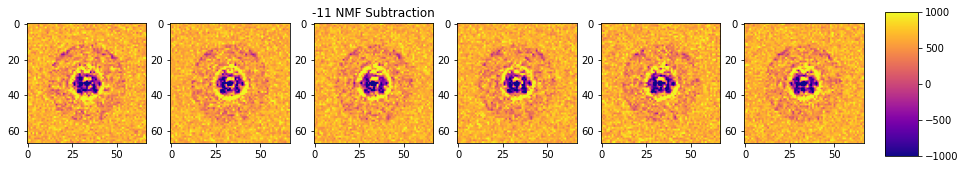

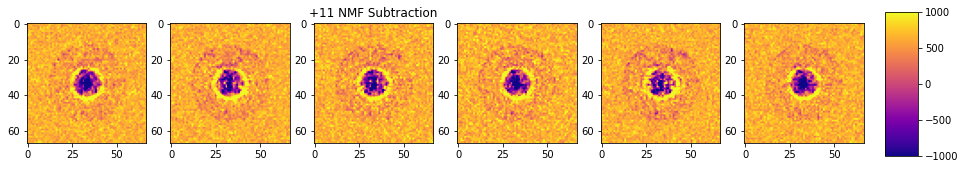

In [19]:
import nmf_imaging

# Create Mask
mask = np.zeros([67,67])
x = np.linspace(-1,1,67)
y = x
x,y = np.meshgrid(x,y)
r = np.sqrt(x**2 + y**2)
mask[r <= 0.75] = 1

# Reference 
refbox = np.zeros([6,67,67])
refbox[0] = dataID1
refbox[1] = dataID6
refbox[2] = dataID7
refbox[3] = dataID12
refbox[4] = dataID13
refbox[5] = dataID18
refbox *= 1

# -11 Target 
m11box = np.zeros([6,67,67])
m11box[0] = dataID2
m11box[1] = dataID4
m11box[2] = dataID9
m11box[3] = dataID11
m11box[4] = dataID14
m11box[5] = dataID16
m11box *= 1e5

# +11 Target
p11box = np.zeros([6,67,67])
p11box[0] = dataID3
p11box[1] = dataID5
p11box[2] = dataID8
p11box[3] = dataID10
p11box[4] = dataID15
p11box[5] = dataID17
p11box *= 1e5


def NMFSubtraction(reference,target,mask):
    
    # Construct Components
    print('Constructing Components...')
    components = nmf_imaging.NMFcomponents(refbox,oneByOne=True,maxiters=1e5)
    
    nmfresults = np.zeros(target.shape)
    
    # NMF Subtraction
    for i in range(m11box.shape[0]):
        trg = target[i]
        model = nmf_imaging.NMFmodelling(trg = trg,
                                         components = components,
                                         n_components = 6,
                                         maxiters=1e5) # Model the target with the constructed components.
        best_frac =  nmf_imaging.NMFbff(trg, model) # Perform BFF procedure to find out the best fraction to model the target.
        result = nmf_imaging.NMFsubtraction(trg, model, frac = best_frac) # Subtract the best model from the target
        nmfresults[i] = result[0]
        
    return nmfresults


vmin = -1e3
vmax = 1e3

resultsm11 = NMFSubtraction(refbox,m11box,mask)
resultsp11 = NMFSubtraction(refbox,p11box,mask)

fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[2].set_title('-11 NMF Subtraction')
ax[0].imshow((resultsm11[0]),vmin=vmin,vmax=vmax)
ax[1].imshow((resultsm11[1]),vmin=vmin,vmax=vmax)
ax[2].imshow((resultsm11[2]),vmin=vmin,vmax=vmax)
ax[3].imshow((resultsm11[3]),vmin=vmin,vmax=vmax)
ax[4].imshow((resultsm11[4]),vmin=vmin,vmax=vmax)
cmap = ax[5].imshow((resultsm11[5]),vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

fig,ax = plt.subplots(ncols=6,figsize=[15,5])
plt.set_cmap('plasma')
ax[2].set_title('+11 NMF Subtraction')
ax[0].imshow((resultsp11[0]),vmin=vmin,vmax=vmax)
ax[1].imshow((resultsp11[1]),vmin=vmin,vmax=vmax)
ax[2].imshow((resultsp11[2]),vmin=vmin,vmax=vmax)
ax[3].imshow((resultsp11[3]),vmin=vmin,vmax=vmax)
ax[4].imshow((resultsp11[4]),vmin=vmin,vmax=vmax)
cmap = ax[5].imshow((resultsp11[5]),vmin=vmin,vmax=vmax)
cbax = fig.add_axes([0.92,0.3,0.03,0.4])
cb = plt.colorbar(cmap,cax=cbax)

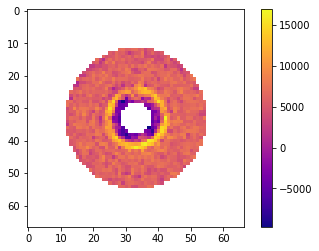

In [20]:
from scipy.ndimage import rotate

def annularmask(array,minrad,maxrad):
    
    xshape = 67/2
    x = np.linspace(-xshape,xshape,67)
    y = x
    x,y = np.meshgrid(x,y)
    rad = np.sqrt(x**2 + y**2)
    
    narray = array
    
    narray[rad<=minrad] = np.NaN
    narray[rad>=maxrad] = np.NaN
    
    return narray

p11 = rotate(np.sum(resultsp11,axis=0),22,reshape=False)
m11 = np.sum(resultsm11,axis=0)

plt.imshow(annularmask(p11+m11,5,22))
plt.colorbar()

# fig,ax = plt.subplots(ncols = 2,figsize=[10,10])
# ax[0].imshow(np.sum(resultsm11,axis=0))
# ax[1].imshow(np.sum(resultsp11,axis=0))
# plt.show()

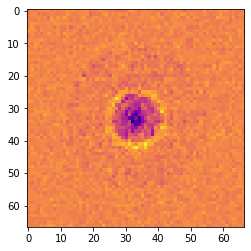

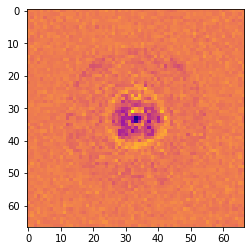